# **Evaluation Metrics & Hyperparameter Tuning**

Created by: Ari Sulistiyo Prabowo

This notebook is created to teach student about an advanced statistic. All the code is free to reuse by everyone

**Contents**
- Evaluation metrics
    - Confusion Matrix
    - Accuracy
    - Precision, Recall & F1-Score
    - ROC Curve
    - Mean Absolute Error, Mean Squared Error, R2 Score
- Hyperparameter Tuning
    - Cross Validation
    - GridSearchCV

_______

In [49]:
# import library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Classification Case**

In [50]:
data = pd.read_csv("https://raw.githubusercontent.com/densaiko/data_science_learning/main/dataset/diabetes.csv")
print(data.shape)
data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Exploratory Data Analysis

In [52]:
# target variable
data['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

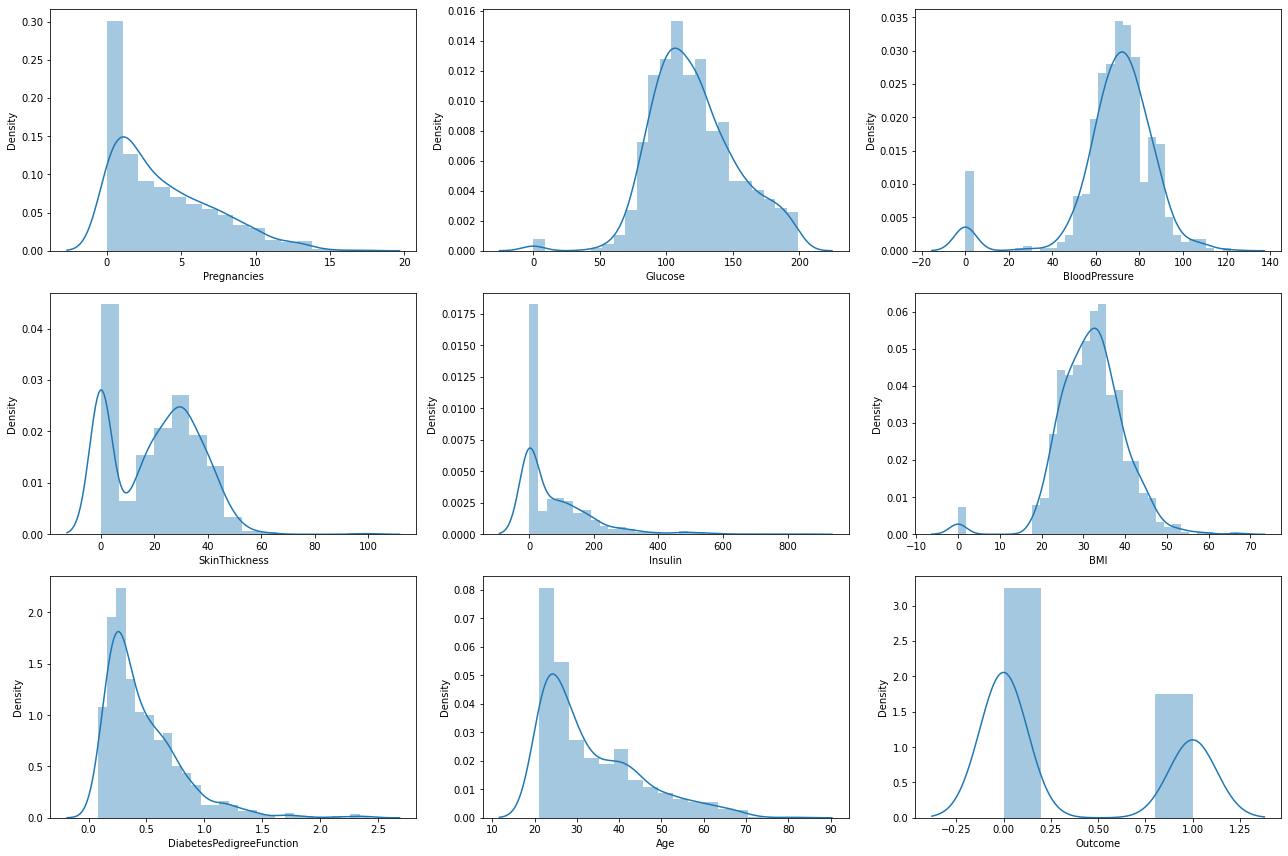

In [53]:
# univariate analysis
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

fig, axes = plt.subplots(3,3, figsize=(18,12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col in enumerate(columns):
  plot = sns.distplot(data[col], ax=axes[i])

plt.tight_layout()

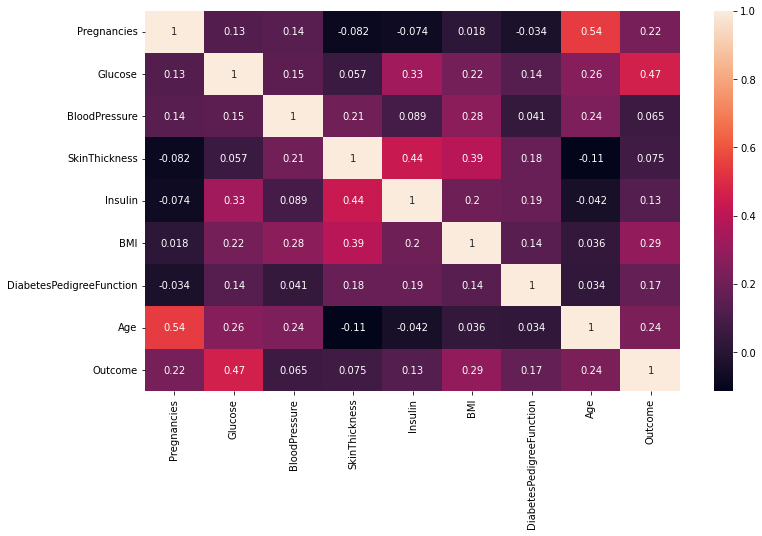

In [54]:
# correlation
plt.figure(figsize=(12,7))
sns.heatmap(data.corr(), annot=True)
plt.show()

#### Modelling & Evaluation

In [55]:
# Show the evaluation metrics using confusion matrix
def confusion(y_true, preds):
  """
  y_true - the y values that are actually true in the dataset (numpy array or pandas series)
  preds - the predictions for those values from some model (numpy array or pandas series)
  """

  tp, fp, fn, tn = confusion_matrix(y_true, preds).ravel()
  print(confusion_matrix(y_true, preds))
  print('')

  print("True Positive: ", format(tp))
  print("False Positive: ", format(fp))
  print("True Negative: ", format(tn))
  print("False Negative: ", format(fn))
  

In [56]:
# Show the evaluation metrics
def evaluation_metrics(y_true, preds, model_name=None):
  """
  y_true - the y values that are actually true in the dataset (numpy array or pandas series)
  preds - the predictions for those values from some model (numpy array or pandas series)
  model_name - (str - optional) a name associated with the model if you would like to add it to the print statements  
  """

  if model_name == None:
    print('Accuracy score: ', format(round(accuracy_score(y_true, preds),4)))
    print('Precision score: ', format(round(precision_score(y_true, preds),4)))
    print('Recall score: ', format(round(recall_score(y_true, preds),4)))
    print('F1 score: ', format(round(f1_score(y_true, preds),4)))

  else:
    print('Accuracy score for ' + model_name + ' :' , format(round(accuracy_score(y_true, preds),4)))
    print('Precision score ' + model_name + ' :', format(round(precision_score(y_true, preds),4)))
    print('Recall score ' + model_name + ' :', format(round(recall_score(y_true, preds),4)))
    print('F1 score ' + model_name + ' :', format(round(f1_score(y_true, preds),4)))

In [57]:
# separating the data
X = data.drop(columns='Outcome')
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [105]:
# Simple machine learning model
clf_rf = RandomForestClassifier()

# Fit the model on the training data
clf_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_rf.predict(X_test)

In [59]:
# confusion matrix
confusion(y_test, y_pred)

[[137  15]
 [ 38  41]]

True Positive:  137
False Positive:  15
True Negative:  41
False Negative:  38


In [97]:
# accuracy, precision, recall and f1-score
evaluation_metrics(y_test, y_pred, model_name="Random Forest")

Accuracy score for Random Forest : 0.7835
Precision score Random Forest : 0.7458
Recall score Random Forest : 0.557
F1 score Random Forest : 0.6377


In [126]:
# Evaluation metrics using ROC curve
def roc_curve_plot(y_test, y_preds):
    '''
    INPUT:
    stuff 
    OUTPUT:
    auc - returns auc as a float
    prints the roc curve
    '''
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.show()
    
    return roc_auc_score(y_test, np.round(y_preds[:, 1]))

In [113]:
y_prob = clf_rf.predict_proba(X_test)

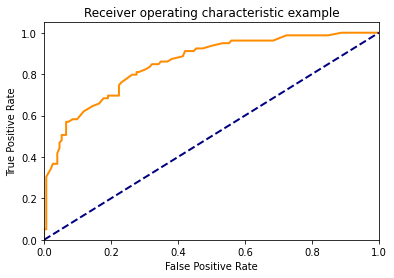

0.7417971352431711

In [128]:
roc_curve_plot(y_test, y_prob)

### **Regression Case**

In [16]:
reg = pd.read_csv("https://raw.githubusercontent.com/densaiko/data_science_learning/main/dataset/boston.csv")
print(reg.shape)
reg.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [17]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


#### Exploratory Data Analysis

In [18]:
reg.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

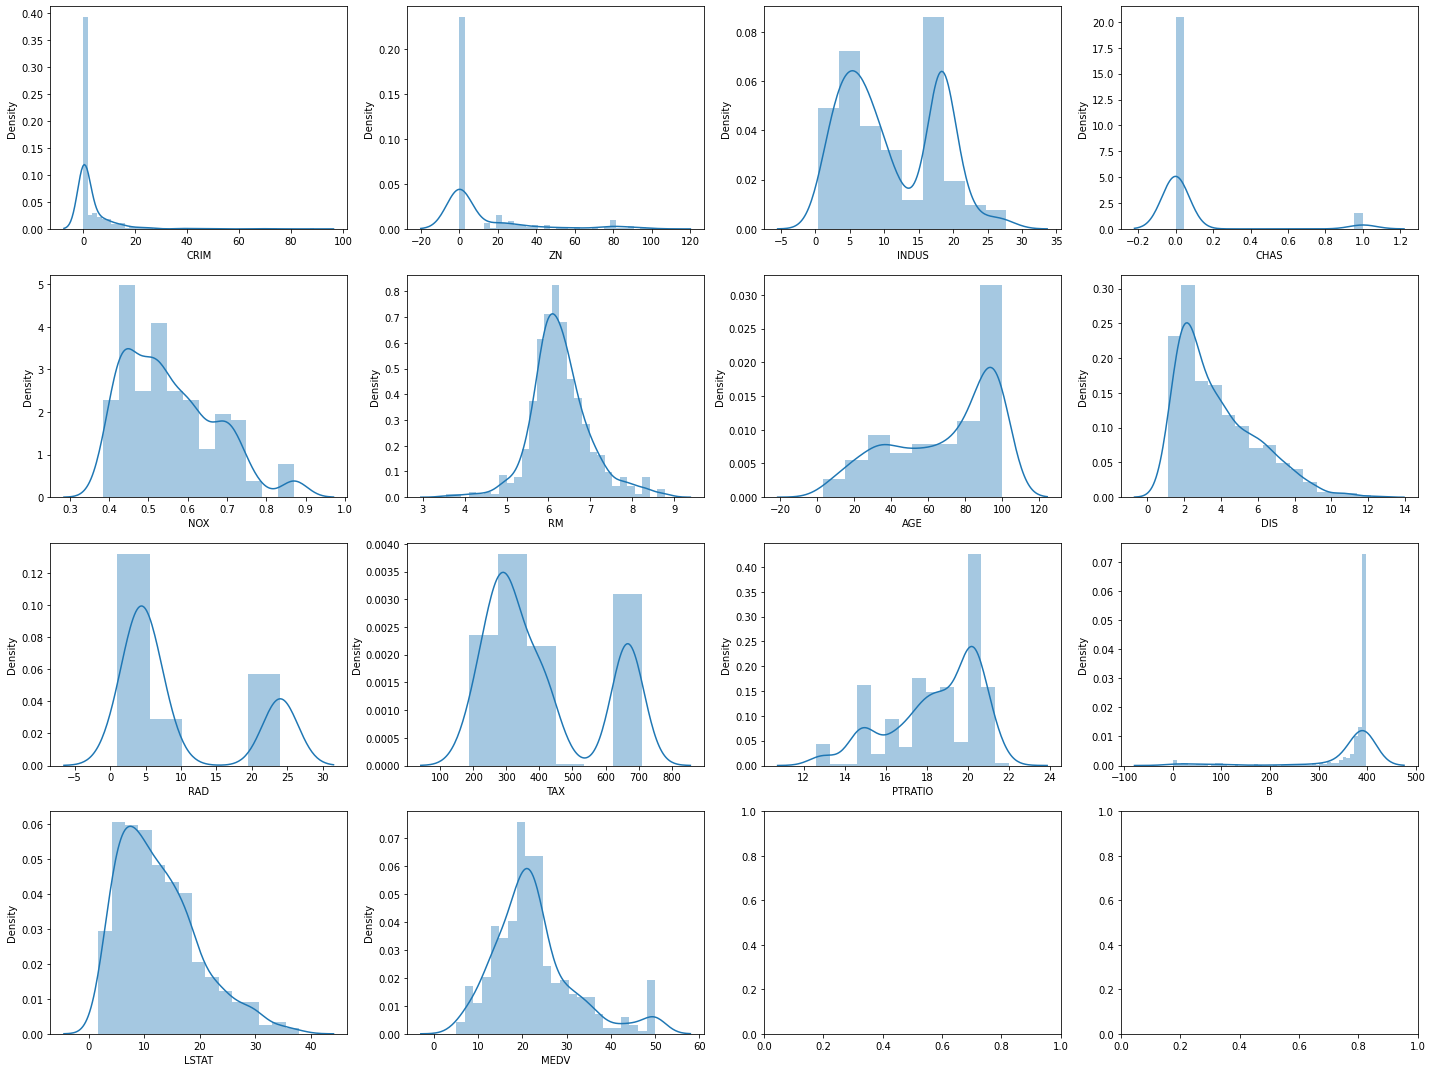

In [20]:
# univariate analysis
reg_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
               'PTRATIO', 'B', 'LSTAT', 'MEDV']

fig, axes = plt.subplots(4,4, figsize=(20,15))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col in enumerate(reg_columns):
  plot = sns.distplot(reg[col], ax=axes[i])

plt.tight_layout()

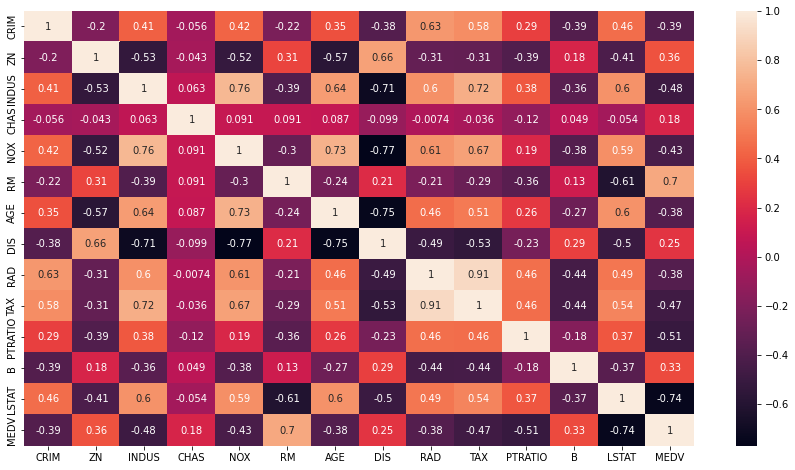

In [21]:
# correlation
plt.figure(figsize=(15,8))
sns.heatmap(reg.corr(), annot=True)
plt.show()

#### Modelling & Evaluation

In [22]:
# Separating training and testing data
X = reg.drop(columns="MEDV")
y = reg['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
#initiate various model
tree_mod = DecisionTreeRegressor()
rf_mod = RandomForestRegressor()
ada_mod = AdaBoostRegressor()
reg_mod = LinearRegression()

In [24]:
# Fit each of your models using the training data
tree_mod.fit(X_train, y_train)
rf_mod.fit(X_train, y_train)
ada_mod.fit(X_train, y_train)
reg_mod.fit(X_train, y_train)

LinearRegression()

In [25]:
# Predict on the test values for each model

preds_tree = tree_mod.predict(X_test) 
preds_rf = rf_mod.predict(X_test)
preds_ada = ada_mod.predict(X_test)
preds_reg = reg_mod.predict(X_test)

In [26]:
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (numpy array or pandas series)
    preds - the predictions for those values from some model (numpy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the mse, mae, r2
    '''
    if model_name == None:
        print('Mean Squared Error: ', format(round(mean_squared_error(y_true, preds),3)))
        print('Mean Absolute Error: ', format(round(mean_absolute_error(y_true, preds),3)))
        print('R2 Score: ', format(round(r2_score(y_true, preds),3)))
        print('\n\n')
    
    else:
        print('Mean Squared Error ' + model_name + ' :' , format(round(mean_squared_error(y_true, preds),3)))
        print('Mean Absolute Error ' + model_name + ' :', format(round(mean_absolute_error(y_true, preds),3)))
        print('R2 Score ' + model_name + ' :', format(round(r2_score(y_true, preds),3)))
        print('\n\n')

In [27]:
print_metrics(y_test,preds_tree,model_name="Decision Tree")

Mean Squared Error Decision Tree : 17.916
Mean Absolute Error Decision Tree : 2.872
R2 Score Decision Tree : 0.763





In [28]:
print_metrics(y_test,preds_rf,model_name="Random Forest")

Mean Squared Error Random Forest : 10.029
Mean Absolute Error Random Forest : 2.146
R2 Score Random Forest : 0.867





In [29]:
print_metrics(y_test,preds_ada,model_name="Ada Boosting")

Mean Squared Error Ada Boosting : 17.443
Mean Absolute Error Ada Boosting : 2.986
R2 Score Ada Boosting : 0.77





In [30]:
print_metrics(y_test,preds_reg,model_name="Linear Regression")

Mean Squared Error Linear Regression : 20.724
Mean Absolute Error Linear Regression : 3.148
R2 Score Linear Regression : 0.726





### **Hyperparameter Tuning**
Specific on classification case

#### Cross Validation

In [77]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [40]:
ex_kf = KFold(n_splits=5, shuffle=False).split(range(25))

# show the training and testing set
print('{} {:^61} {}'.format("Iteration","Training set observation","Testing set observation"))

for i, k in enumerate(ex_kf, start=1):
  print("{:^9} {} {:^25}".format(i, k[0], str(k[1])))

Iteration                   Training set observation                    Testing set observation
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


In [64]:
# separating the data
X = data.drop(columns='Outcome')
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [67]:
# Simple machine learning model
clf_rf = RandomForestClassifier()

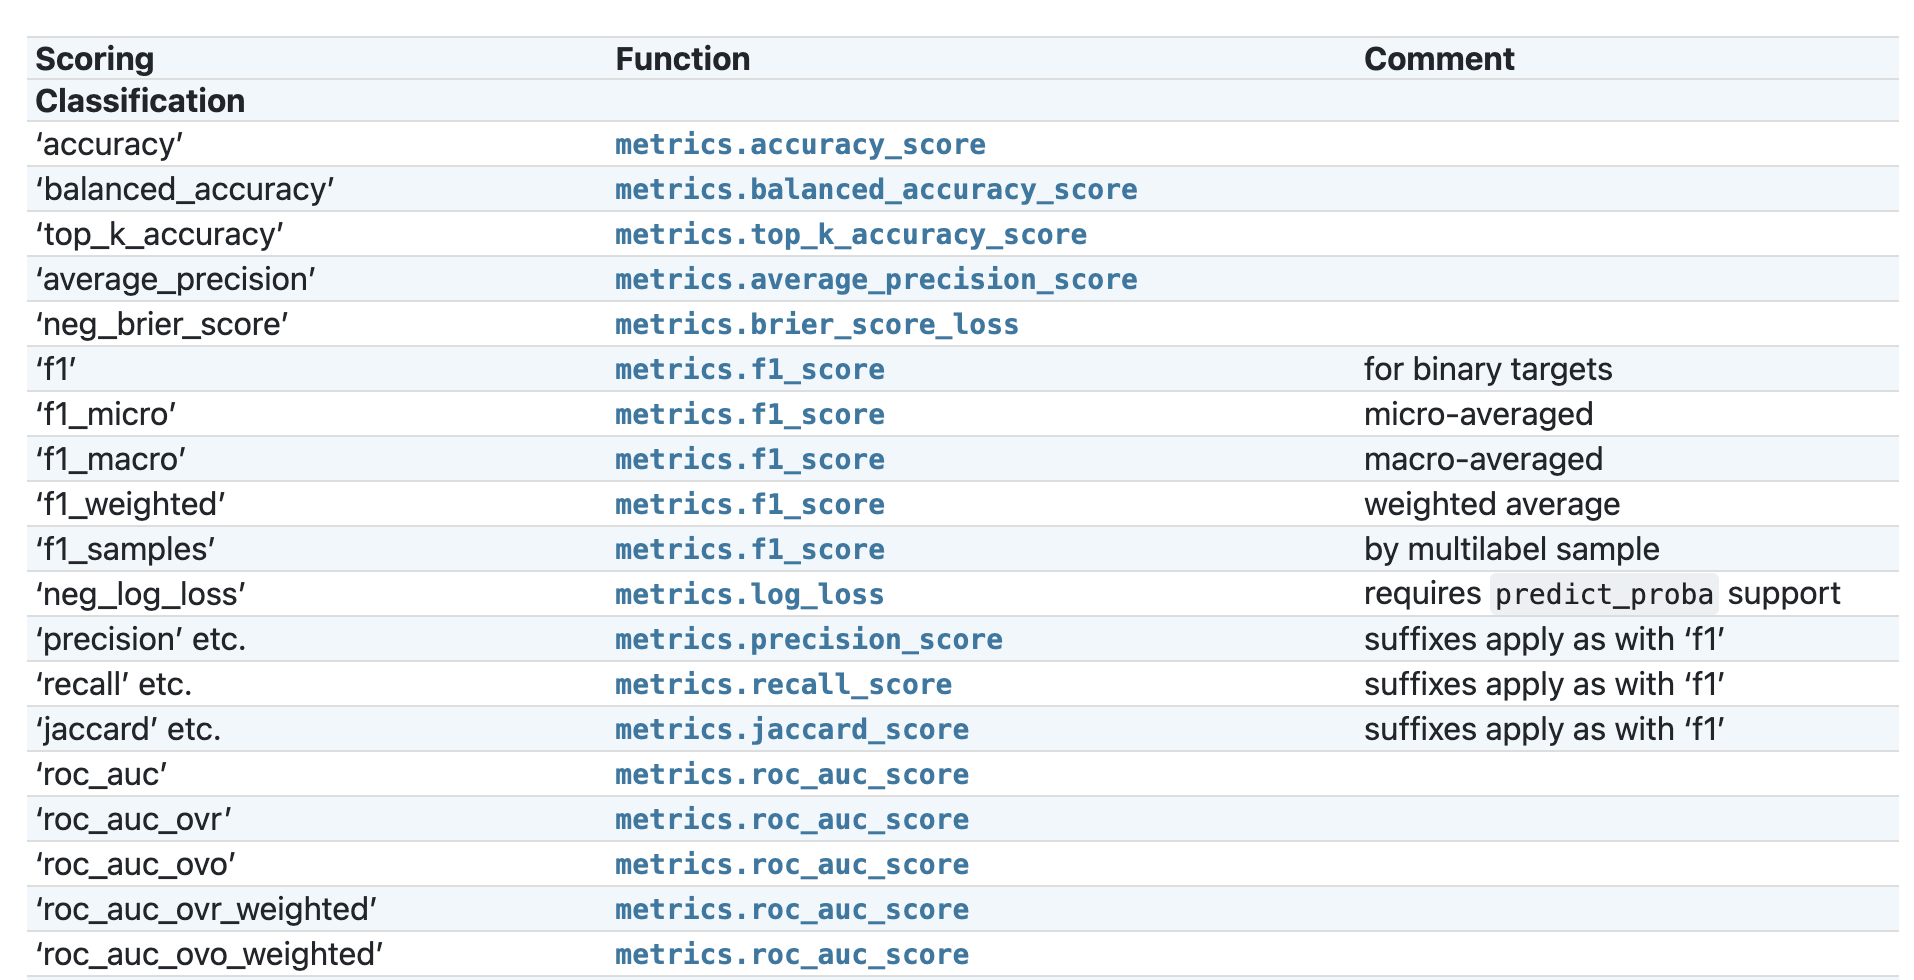

In [76]:
# Using cross validation with 10 fold
scores = cross_val_score(clf_rf, X, y, cv=10, scoring='roc_auc')
print(scores)
print()
print("Average of accuracy using CV 10 fold ({:.5f}) and the standard deviation ({:.5f})".format(scores.mean(), scores.std()))

[0.76777778 0.81888889 0.81814815 0.74296296 0.80037037 0.86222222
 0.87222222 0.90222222 0.80730769 0.85230769]

Average of accuracy using CV 10 fold (0.82444) and the standard deviation (0.04618)


#### Grid Search CV

In [85]:
# Random forest classifier
clf_rf = RandomForestClassifier()

param_dist = {"max_depth": [3, None],
              "min_samples_split": list(range(2, 7)),
              "min_samples_leaf": list(range(1, 5)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run a Grid Search CV over the hyperparameters
grid_objt = GridSearchCV(clf_rf, param_grid=param_dist)

# Fit the model on the training data
grid_objt.fit(X_train, y_train)

# show the best estimator that we have choosed
grid_objt.best_estimator_

RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=4,
                       min_samples_split=4)

In [86]:
# Make predictions on the test data
rf_preds = grid_objt.best_estimator_.predict(X_test)

evaluation_metrics(y_test, rf_preds, 'random forest')

Accuracy score for random forest : 0.7749
Precision score random forest : 0.7077
Recall score random forest : 0.5823
F1 score random forest : 0.6389


In [123]:
rf_prob = grid_objt.best_estimator_.predict_proba(X_test)

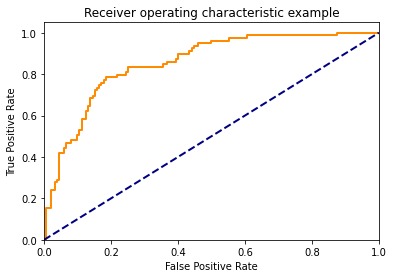

0.7286392405063291

In [129]:
roc_curve_plot(y_test, rf_prob)